Import The Libraries

In [124]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Import The Dataset

In [125]:
df = pd.read_excel('retail.xlsx')
df.head(n=10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [126]:
df = df[df['CustomerID'].notna()]

Sample the dataset

In [127]:
df_fix = df.sample(10000, random_state = 42)
df_fix.head(n=10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom
234751,557598,22558,CLOTHES PEGS RETROSPOT PACK 24,2,2011-06-21 11:33:00,1.65,14667.0,United Kingdom
283269,561704,21533,RETROSPOT LARGE MILK JUG,1,2011-07-29 11:07:00,4.95,14606.0,United Kingdom
532936,581001,22726,ALARM CLOCK BAKELIKE GREEN,24,2011-12-07 08:07:00,3.75,12583.0,France
78561,542890,84865,NEW BAROQUE BLACK PHOTO ALBUM,2,2011-02-01 13:25:00,8.50,15311.0,United Kingdom
424855,573287,21314,SMALL GLASS HEART TRINKET POT,8,2011-10-28 14:42:00,2.10,14194.0,United Kingdom


Convert to show date only

In [128]:
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

Create TotalSum colummn

In [129]:
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

Create date variable that records recency

In [130]:
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

Aggregate data by each customer

In [131]:
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

Rename columns

In [132]:
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [133]:
customers.head(n=10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30
12357.0,34,4,298.32
12358.0,151,1,80.00
12359.0,58,3,54.64
12360.0,113,3,33.40


Skewness and Scaling

In [134]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values


In [135]:
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


Import library

In [136]:
from sklearn.preprocessing import StandardScaler

Initialize the Object

In [137]:
scaler = StandardScaler()

Fit and Transform The Data

In [138]:
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

Assert that it has mean 0 and variance 1

In [139]:
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


Modelling

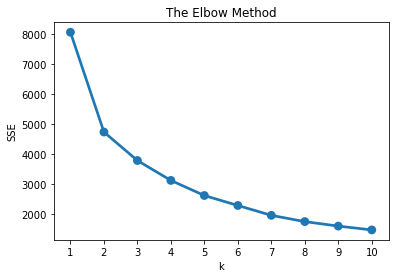

In [140]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [141]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)

KMeans(n_clusters=3, random_state=42)

In [142]:
model.labels_.shape

(2690,)

Interpret The Segment

In [143]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         47.21      1.62         21.58   808
1        226.64      1.64         28.66   960
2         46.31      7.72        166.06   922

Create the dataframe

In [144]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

Melt The Data

In [145]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-0.493794
1,12348.0,1,Recency,1.232949
2,12349.0,2,Recency,-0.994917
3,12352.0,2,Recency,-0.012582
4,12354.0,1,Recency,1.155005


Visualize it

<AxesSubplot:xlabel='Attribute', ylabel='Value'>

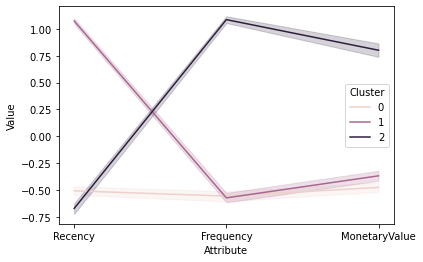

In [146]:
sns.lineplot( x='Attribute',y='Value',data=df_nor_melt,hue='Cluster')